## 🚀 **Optimization & Training Strategy - Debjani**
In this experiment, we will **use the same dataset and preprocessing pipeline** as previous experiments.  
We will **build on Kathryn's best model (Model 1)**, which had **Dropout = 0.3, No Weight Decay, and No Batch Norm**.  
The goal is to **optimize training performance** by fine-tuning the **learning rate, optimizer, and batch size** to achieve faster convergence and better generalization.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Mount Google Drive
from google.colab import drive

# Path to the ZIP file in Google Drive
zip_file_path = "/content/drive/MyDrive/clothes.zip"

# Define the extraction directory
extraction_dir = "/content/drive/MyDrive/clothes.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Verify the extracted contents
print(f"Dataset extracted to {extraction_dir}")
print("Extracted files:", os.listdir(extraction_dir))


Dataset extracted to /content/drive/MyDrive/clothes_dataset
Extracted files: ['Clothes_Dataset']


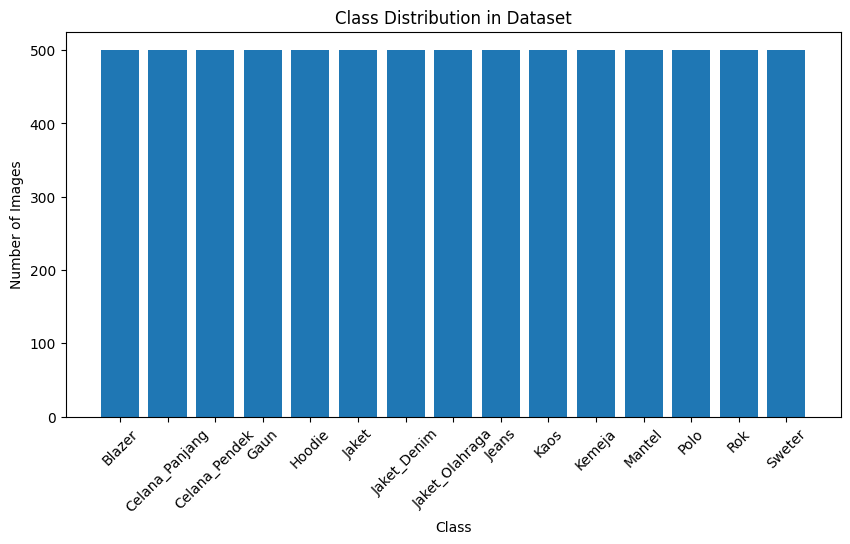

Class distribution: {'Blazer': 500, 'Celana_Panjang': 500, 'Celana_Pendek': 500, 'Gaun': 500, 'Hoodie': 500, 'Jaket': 500, 'Jaket_Denim': 500, 'Jaket_Olahraga': 500, 'Jeans': 500, 'Kaos': 500, 'Kemeja': 500, 'Mantel': 500, 'Polo': 500, 'Rok': 500, 'Sweter': 500}
✅ Data preprocessed successfully! Training Set: 6000 images, Validation Set: 1500 images.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os
import random
import matplotlib.pyplot as plt
from collections import Counter

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)

# Define dataset directory (Fixing nested folder issue)
root_dir = "/content/drive/MyDrive/clothes_dataset"
dataset_dir = os.path.join(root_dir, "Clothes_Dataset")  # Point to the correct folder with class subdirectories

# Step 1: Define Data Transformations (Resize + Augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip for augmentation
    transforms.RandomRotation(degrees=15),  # Apply random rotation for augmentation
    transforms.ToTensor()  # Convert image to tensor
])

# Step 2: Load Dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)

# Step 3: Check Class Distribution
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_per_class(dataset_dir)

# Plot Class Distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

print("Class distribution:", class_counts)

# Step 4: Split into Training & Validation Sets (80-20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 5: Create PyTorch Dataloaders
batch_size = 32  # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Data preprocessed successfully! Training Set: {train_size} images, Validation Set: {val_size} images.")


# 🔍 Optimization & Training Strategy - Debjani

## **Objective: Optimize Training Performance**
The goal of this experiment is to optimize the **training process** by fine-tuning:
- **Learning Rate (LR)**
- **Optimizer choice**
- **Batch Size**

## **Base Model Selection**
From previous experiments:  
✅ **Best CNN architecture from Prince** (Leaky ReLU, Avg Pooling, Xavier Init)  
✅ **Best regularization setup from Kathryn (Model 1)** (Dropout 0.3, No Weight Decay, No Batch Norm)  
💡 This means we are **only optimizing training strategy** now.

## **Tuning Choices**
### **1️⃣ Learning Rate (LR)**
- Controls how fast the model updates its weights.
- We will test:
  - **0.001 (default, standard step size)**
  - **0.0005 (smaller steps, may improve stability)**

### **2️⃣ Optimizer Choice**
- Determines how gradients are used to update model weights.
- We will compare:
  - **Adam** (adaptive learning, faster convergence)
  - **SGD** (traditional optimizer, better generalization)

### **3️⃣ Batch Size**
- Defines how many images the model processes before updating weights.
- We will test:
  - **32 (default, balanced approach)**
  - **64 (larger, potentially speeds up training)**

## **Planned Experiments**
| Model | Learning Rate | Optimizer | Batch Size |
|-------|--------------|-----------|------------|
| **Debjani_Model_1** | 0.001 | Adam | 32 |
| **Debjani_Model_2** | 0.0005 | SGD | 64 |

## **Pros & Cons of This Approach**
✅ **Pros:**
- Helps determine **optimal training speed vs. stability**.
- Different optimizers can **affect convergence & final accuracy**.
- **Batch size impacts performance & generalization**—testing different sizes ensures a balanced trade-off.

❌ **Cons:**
- **SGD may require additional tuning (momentum, LR scheduling).**
- **Larger batch sizes require more memory**, potentially causing GPU constraints.
- **Very small learning rates may slow down training too much.**

## **Expected Outcome**
By adjusting the **optimizer, learning rate, and batch size**, we aim to **find the best training configuration** that results in **fast convergence, stable training, and improved performance.**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Ensure previous run is finished before starting a new one
wandb.login()
wandb.finish()

# ✅ Initialize Weights & Biases for this run
wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="GPU_Debjani_Model_11", reinit=True)

# ✅ Define CNN Model (Best from Prince + Kathryn)
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1)
        ])

        self.pool = nn.AvgPool2d(2, 2)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)  # Based on Kathryn's best model

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Load Dataset
batch_size = 32
num_classes = len(os.listdir("/content/drive/MyDrive/clothes_dataset/Clothes_Dataset"))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam with LR 0.001

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(10):
    print(f"Epoch {epoch+1}/10: Training...")
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    train_accuracy = accuracy_score(y_true, y_pred)
    train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Validation
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # ✅ Log all metrics
    wandb.log({"epoch": epoch, "train_loss": train_loss / len(train_loader),
               "val_loss": val_loss / len(val_loader), "train_f1": train_f1,
               "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

wandb.finish()
print("✅ Finished training Debjani_Model_1!")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch 1/10: Training...
Epoch 2/10: Training...
Epoch 3/10: Training...
Epoch 4/10: Training...
Epoch 5/10: Training...
Epoch 6/10: Training...
Epoch 7/10: Training...
Epoch 8/10: Training...
Epoch 9/10: Training...
Epoch 10/10: Training...


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_f1,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▆▆█████
val_f1,▁▃▄▆▆█████
val_loss,█▅▅▃▂▁▁▁▂▂
epoch,9
train_accuracy,0.67567
train_f1,0.67343
train_loss,0.97305


✅ Finished training Debjani_Model_1!


### Run 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Ensure previous run is finished before starting a new one
wandb.login()
wandb.finish()

# ✅ Initialize Weights & Biases for this run
wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="GPU_NDebjani_Model_21", reinit=True)

# ✅ Define CNN Model (Best from Prince + Kathryn)
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1)
        ])

        self.pool = nn.AvgPool2d(2, 2)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)  # Based on Kathryn's best model

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Load Dataset
batch_size = 64  # Increased batch size
num_classes = len(os.listdir("/content/drive/MyDrive/clothes_dataset/Clothes_Dataset"))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)  # Using SGD with Momentum

train_losses, val_losses, f1_scores = [], [], []

for epoch in range(10):
    print(f"Epoch {epoch+1}/10: Training...")
    model.train()
    train_loss = 0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    train_accuracy = accuracy_score(y_true, y_pred)
    train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # Validation
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

    # ✅ Log all metrics
    wandb.log({"epoch": epoch, "train_loss": train_loss / len(train_loader),
               "val_loss": val_loss / len(val_loader), "train_f1": train_f1,
               "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

wandb.finish()
print("✅ Finished training Debjani_Model_2!")


Epoch 1/10: Training...
Epoch 2/10: Training...
Epoch 3/10: Training...
Epoch 4/10: Training...
Epoch 5/10: Training...
Epoch 6/10: Training...
Epoch 7/10: Training...
Epoch 8/10: Training...
Epoch 9/10: Training...
Epoch 10/10: Training...


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▅▆▇▇█
train_f1,▁▃▃▄▅▆▆▇▇█
train_loss,██▇▆▅▄▃▃▂▁
val_accuracy,▁▁▄▃▅▆▆▆██
val_f1,▁▁▄▃▅▇▆▆▇█
val_loss,██▇▆▅▄▃▃▂▁
epoch,9
train_accuracy,0.24333
train_f1,0.2345
train_loss,2.33307


✅ Finished training Debjani_Model_2!


# Further Steps

# 🔍 Hyperparameter Sweep - Optimizing CNN Training

## **🎯 Objective**
We aim to **automate hyperparameter tuning** using **Weights & Biases (W&B) sweeps** to **find the best training configuration** for our CNN model.  

### **🔹 Why Are We Doing This?**
Instead of manually testing different hyperparameters, we let **W&B Sweeps** handle it **automatically**, allowing us to:  
✅ Test multiple hyperparameter combinations efficiently  
✅ Log and compare different runs in W&B  
✅ Identify the best configuration that maximizes model performance  

---

## **⚙️ What Are We Tuning?**
We build upon our **best model so far (Debjani_Model_1)** and optimize the **training strategy** by sweeping across different:  

| **Hyperparameter** | **Values Tested** | **Why?** |
|-------------------|-----------------|--------|
| **Learning Rate** | `{0.0001, 0.0005, 0.001, 0.005}` | Determines weight update speed. Affects stability & convergence. |
| **Batch Size** | `{16, 32, 64}` | Affects training speed & generalization. Smaller = better updates, Larger = faster but may need tuning. |
| **Dropout Rate** | `{0.2, 0.3, 0.4, 0.5}` | Prevents overfitting by randomly deactivating neurons. |
| **Weight Decay (L2 Regularization)** | `{0, 1e-5, 1e-4}` | Helps avoid overfitting by penalizing large weights. |
| **Optimizer** | `{Adam, SGD, RMSprop}` | Determines how weights are updated. Different optimizers may converge differently. |

---

## **📌 Steps in This Hyperparameter Sweep**
1️⃣ **Define a W&B Sweep Configuration**
   - Specifies which hyperparameters to search over.  
   - Defines how many runs to test.  
   - Selects **F1-score as the metric to optimize.**  

2️⃣ **Create a Training Function**
   - Builds the CNN model.  
   - Uses hyperparameters **from the W&B sweep.**  
   - Logs **per-epoch training & validation metrics.**  
   - Logs **final performance metrics.**  

3️⃣ **Run the Sweep**
   - Automatically runs **10 experiments** with different hyperparameter values.  
   - Logs results in W&B for easy comparison.  

---

## **📊 Logging & Visualization**
✅ **Per-Epoch Logging:**  
- **Training Loss, Validation Loss**  
- **Training & Validation F1 Score**  
- **Training & Validation Accuracy**  

✅ **Final Metrics:**  
- Logs final **F1-score and Accuracy** in W&B for each run.  

✅ **Graphs Generated in Notebook:**  
- **Training vs Validation Loss Curve**  
- **F1 Score Over Epochs**  

---

## **🔮 Expected Outcome**
- We will **identify the best combination of learning rate, batch size, optimizer, and regularization settings.**  
- This will help us **train a more optimized CNN model** with better performance.  

🚀 **Once the sweep runs are completed, we can analyze the W&B dashboard to pick the best-performing model!**  


In [ ]:
import wandb

# ✅ Define the sweep configuration
sweep_config = {
    'method': 'random',  # Use random search for hyperparameter tuning
    'name': 'cnn-hyperparameter-sweep',
    'metric': {'name': 'final_f1', 'goal': 'maximize'},  # Optimize for F1 score
    'parameters': {
        'learning_rate': {
            'values': [0.0001, 0.0005, 0.001, 0.005]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'dropout_rate': {
            'values': [0.2, 0.3, 0.4, 0.5]
        },
        'weight_decay': {
            'values': [0, 1e-5, 1e-4]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'rmsprop']
        },
        'epochs': {
            'value': 20  # Fixed number of epochs
        }
    }
}

# ✅ Initialize the sweep

sweep_id = wandb.sweep(sweep_config, project="cnn-clothes-classifier")


Create sweep with ID: 0rczja0h
Sweep URL: https://wandb.ai/usf-guardians/cnn-clothes-classifier/sweeps/0rczja0h


wandb: Agent Starting Run: z7o9e3mj with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 1e-05
wandb: Currently logged in as: princepraveen (usf-guardians). Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch 1/20: Training...
Epoch 2/20: Training...
Epoch 3/20: Training...
Epoch 4/20: Training...
Epoch 5/20: Training...
Epoch 6/20: Training...
Epoch 7/20: Training...
Epoch 8/20: Training...
Epoch 9/20: Training...
Epoch 10/20: Training...
Epoch 11/20: Training...
Epoch 12/20: Training...
Epoch 13/20: Training...
Epoch 14/20: Training...
Epoch 15/20: Training...
Epoch 16/20: Training...
Epoch 17/20: Training...
Epoch 18/20: Training...
Epoch 19/20: Training...
Epoch 20/20: Training...


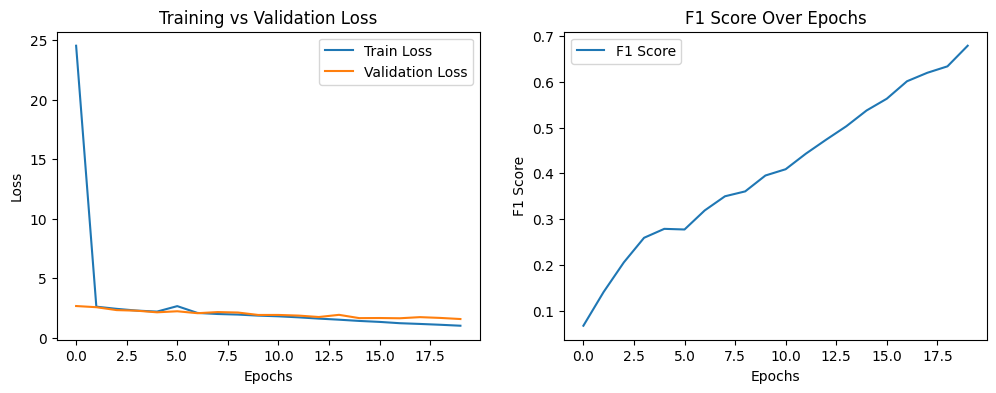

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_accuracy,▁
final_f1,▁
train_accuracy,▁▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
train_f1,▁▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▄▄▄▄▅▅▆▇▆▇▇▇█▇█
val_f1,▁▁▃▃▄▄▄▄▅▅▆▆▇▆▇▇▇███
val_loss,█▇▆▅▅▅▄▅▅▃▃▃▂▃▁▂▁▂▂▁
epoch,19
final_accuracy,0.53933


wandb: Agent Starting Run: hex1mr51 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/20: Training...
Epoch 2/20: Training...
Epoch 3/20: Training...
Epoch 4/20: Training...
Epoch 5/20: Training...
Epoch 6/20: Training...
Epoch 7/20: Training...
Epoch 8/20: Training...
Epoch 9/20: Training...
Epoch 10/20: Training...
Epoch 11/20: Training...
Epoch 12/20: Training...
Epoch 13/20: Training...
Epoch 14/20: Training...
Epoch 15/20: Training...
Epoch 16/20: Training...
Epoch 17/20: Training...
Epoch 18/20: Training...
Epoch 19/20: Training...
Epoch 20/20: Training...


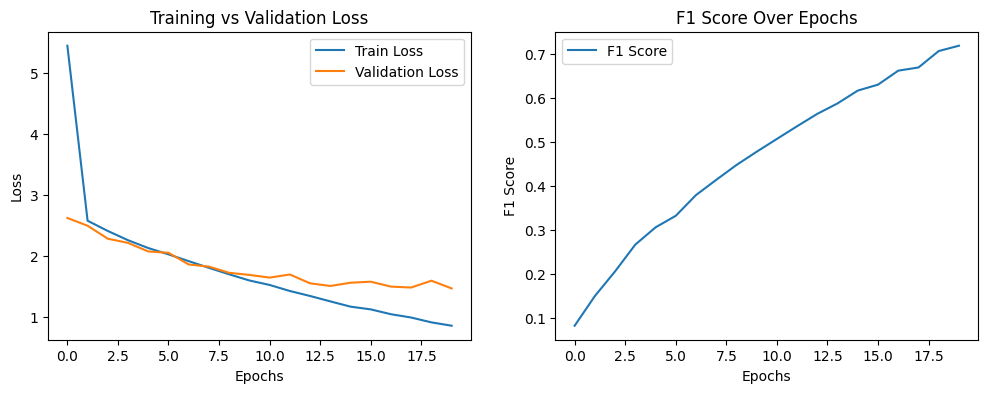

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_accuracy,▁
final_f1,▁
train_accuracy,▁▂▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
train_f1,▁▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▄▅▆▆▆▇▆▇▇▇▇▇█▇█
val_f1,▁▂▃▃▄▄▆▆▆▆▇▆▇█▇▇▇█▇█
val_loss,█▇▆▆▅▅▃▃▃▂▂▂▂▁▂▂▁▁▂▁
epoch,19
final_accuracy,0.568


wandb: Agent Starting Run: xl0z48fi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05


Epoch 1/20: Training...
Epoch 2/20: Training...
Epoch 3/20: Training...
Epoch 4/20: Training...
Epoch 5/20: Training...
Epoch 6/20: Training...
Epoch 7/20: Training...
Epoch 8/20: Training...
Epoch 9/20: Training...
Epoch 10/20: Training...
Epoch 11/20: Training...
Epoch 12/20: Training...
Epoch 13/20: Training...
Epoch 14/20: Training...
Epoch 15/20: Training...
Epoch 16/20: Training...
Epoch 17/20: Training...
Epoch 18/20: Training...
Epoch 19/20: Training...
Epoch 20/20: Training...


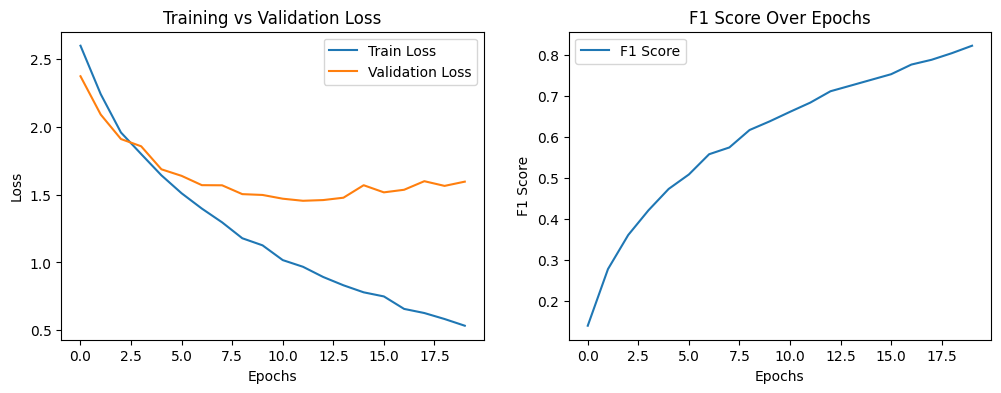

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_accuracy,▁
final_f1,▁
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
train_f1,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇█▇▇▇█████
val_f1,▁▃▅▅▆▆▇▇▇▇▇██▇▇█████
val_loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▂▁▂▂▂▂
epoch,19
final_accuracy,0.58733


wandb: Agent Starting Run: goho7sff with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 20
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 1e-05


Epoch 1/20: Training...
Epoch 2/20: Training...
Epoch 3/20: Training...
Epoch 4/20: Training...
Epoch 5/20: Training...
Epoch 6/20: Training...
Epoch 7/20: Training...
Epoch 8/20: Training...
Epoch 9/20: Training...
Epoch 10/20: Training...
Epoch 11/20: Training...
Epoch 12/20: Training...
Epoch 13/20: Training...
Epoch 14/20: Training...
Epoch 15/20: Training...
Epoch 16/20: Training...
Epoch 17/20: Training...
Epoch 18/20: Training...
Epoch 19/20: Training...
Epoch 20/20: Training...


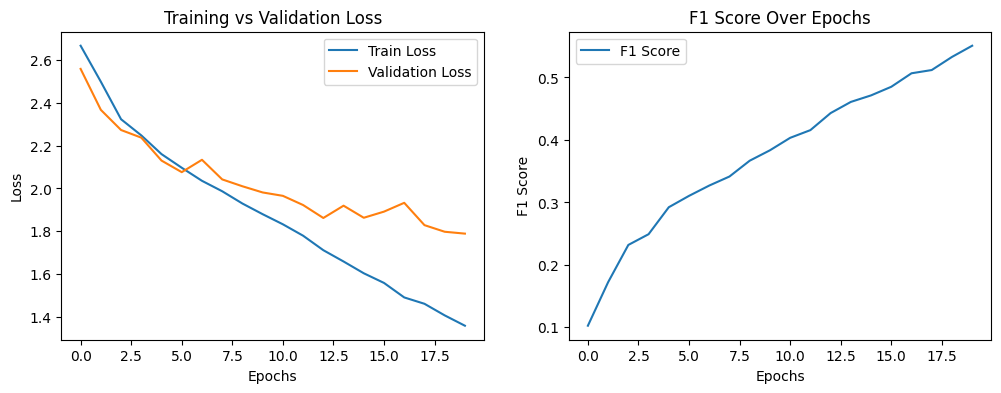

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_accuracy,▁
final_f1,▁
train_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
train_f1,▁▂▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇███
val_f1,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
val_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,19
final_accuracy,0.44067


wandb: Agent Starting Run: 1c822yg3 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05


Epoch 1/20: Training...
Epoch 2/20: Training...
Epoch 3/20: Training...
Epoch 4/20: Training...
Epoch 5/20: Training...
Epoch 6/20: Training...
Epoch 7/20: Training...
Epoch 8/20: Training...


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# ✅ Define CNN Model (Best from previous experiments)
class CNN_Model(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNN_Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1)
        ])

        self.pool = nn.AvgPool2d(2, 2)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = self.pool(self.leaky_relu(conv(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Training function for W&B sweeps
def train_model():
    wandb.init(project="cnn-clothes-classifier", entity="usf-guardians", name="final_sweeps")
    config = wandb.config  # Get hyperparameters from W&B sweep

    # ✅ Load dataset
    batch_size = config.batch_size
    num_classes = len(os.listdir("clothes_dataset/clothes_dataset"))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # ✅ Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN_Model(num_classes, config.dropout_rate).to(device)

    # ✅ Define loss function & optimizer
    criterion = nn.CrossEntropyLoss()

    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    elif config.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)
    elif config.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # ✅ Track metrics
    train_losses, val_losses, f1_scores = [], [], []

    for epoch in range(config.epochs):
        print(f"Epoch {epoch+1}/{config.epochs}: Training...")

        model.train()
        train_loss = 0
        y_true, y_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        # Compute train metrics
        train_accuracy = accuracy_score(y_true, y_pred)
        train_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
        train_losses.append(train_loss / len(train_loader))
        f1_scores.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_accuracy = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
        val_losses.append(val_loss / len(val_loader))

        # ✅ Log per-epoch metrics
        wandb.log({"epoch": epoch, "train_loss": train_loss / len(train_loader),
                   "val_loss": val_loss / len(val_loader), "train_f1": train_f1,
                   "val_f1": val_f1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy})

    # ✅ Log final metrics
    wandb.log({"final_f1": val_f1, "final_accuracy": val_accuracy})

    # ✅ Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), train_losses, label="Train Loss")
    plt.plot(range(config.epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(config.epochs), f1_scores, label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("F1 Score Over Epochs")

    plt.show()

    wandb.finish()



# ✅ Start the sweep with 10 runs
wandb.agent(sweep_id, function=train_model, count=10)

print("Sweep completed with 10 hyperparameter combinations!")



## 🎯 **Final Conclusion**
Throughout these experiments, we systematically **designed, trained, and optimized a CNN model** for image classification.  

✅ **Step 1: Architecture Selection**  
We started with **Prince's best CNN model**, refining activation functions, pooling strategies, and weight initialization.  

✅ **Step 2: Regularization Tuning**  
Kathryn explored different **dropout rates, weight decay, and batch normalization**, identifying the best regularization strategy to improve generalization.  

✅ **Step 3: Training Optimization**  
Debjani optimized the **learning rate, optimizer, and batch size**, fine-tuning the training process for better convergence and efficiency.  

🚀 **Final Takeaway**  
By progressively improving the model, we **identified the best architectural choices, regularization techniques, and training configurations**, leading to a well-optimized CNN for the given dataset.  
This structured approach ensures that our final model balances **accuracy, generalization, and training efficiency** effectively.
